In [16]:
# Import Libraries
import numpy as np  # to handle matrix
import pandas as pd # to handle data
from matplotlib import pyplot as plt # to visualize
import datetime, pytz # to handle time

from sklearn.model_selection import train_test_split # Split data
from sklearn.ensemble import RandomForestRegressor # Random Forest Classifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import plot_confusion_matrix

import seaborn as sns

In [2]:
df = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
df.head(3)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
from datetime import datetime 
df.Timestamp = pd.to_datetime(df.Timestamp, unit='s')

# Resampling to daily frequency
df.index = df.Timestamp
df = df.resample('D').mean()
df.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31,4.465000,4.482500,4.465000,4.482500,23.829470,106.330084,4.471603
2012-01-01,4.806667,4.806667,4.806667,4.806667,7.200667,35.259720,4.806667
2012-01-02,5.000000,5.000000,5.000000,5.000000,19.048000,95.240000,5.000000
2012-01-03,5.252500,5.252500,5.252500,5.252500,11.004660,58.100651,5.252500
2012-01-04,5.200000,5.223333,5.200000,5.223333,11.914807,63.119577,5.208159


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3379 entries, 2011-12-31 to 2021-03-31
Freq: D
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open               3376 non-null   float64
 1   High               3376 non-null   float64
 2   Low                3376 non-null   float64
 3   Close              3376 non-null   float64
 4   Volume_(BTC)       3376 non-null   float64
 5   Volume_(Currency)  3376 non-null   float64
 6   Weighted_Price     3376 non-null   float64
dtypes: float64(7)
memory usage: 211.2 KB


In [5]:
daily_df = df

In [6]:
# Volume is single event so fill "NaN"s with zeroes for relevant fields
daily_df['Volume_(BTC)'].fillna(value=0, inplace=True)
daily_df['Volume_(Currency)'].fillna(value=0, inplace=True)
daily_df['Weighted_Price'].fillna(value=0, inplace=True)


# (open, high, low, close) data which is a continuous timeseries so 'fill forwards' those values
daily_df['Open'].fillna(method='ffill', inplace=True)
daily_df['High'].fillna(method='ffill', inplace=True)
daily_df['Low'].fillna(method='ffill', inplace=True)
daily_df['Close'].fillna(method='ffill', inplace=True)

print("Shape: ", daily_df.shape)
print("Columns= ", daily_df.columns)
print("Is There any 'NaN' value: ", daily_df.isnull().values.any())
print("Is there any duplicate value: ", daily_df.index.duplicated().any())

Shape:  (3379, 7)
Columns=  Index(['Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)',
       'Weighted_Price'],
      dtype='object')
Is There any 'NaN' value:  False
Is there any duplicate value:  False


In [7]:
# There is a library called ta, which creates many technical indicators, like moving averages(and many more). 
# It is originally designed for analyzing stock data, but also works for Bitcoin. 
# It adds more than 80 features to the dataset.

In [8]:
from ta import add_all_ta_features
from ta.utils import dropna

pd.set_option('display.max_columns', None)

df = dropna(daily_df)
df = add_all_ta_features(
    daily_df, open="Open", high="High", low="Low", close="Close", volume="Volume_(BTC)")

df = daily_df.fillna(0)
df.tail()

/Users/hebymathew/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/hebymathew/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_vwap,volume_mfi,volume_nvi,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_atr,volatility_ui,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_conv,trend_ichimoku_base,trend_ichimoku_a,trend_ichimoku_b,trend_stc,trend_adx,trend_adx_pos,trend_adx_neg,trend_cci,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-27,55193.240643,55219.665031,55168.757372,55195.415367,1.823877,100884.732367,55193.357260,113.490059,3392.823677,0.030137,-1017.612931,5.448459e+12,-2.907324e+11,0.139486,56090.720941,43.767220,392610.177102,56079.607775,60765.848493,51393.367057,16.712816,0.405661,0.0,0.0,56004.092198,56074.000171,55934.184224,0.249653,-5.283867,0.0,1.0,50767.843850,60488.868334,55628.356092,17.334330,0.455463,1544.413854,7.641959,1112.845874,1894.490139,-781.644264,55962.842294,54475.421293,55192.688075,54079.842200,0.974784,0.977527,-0.002742,0.535764,23.922623,-735.910692,115.847471,163.099646,-47.252175,55443.195427,54084.024573,54763.610000,48999.262955,1.282880,18.853064,51.716191,45.816760,-31.328072,49107.928987,44092.340863,48.0,12.0,36.0,0.000000,59616.976251,0.0,0.0,53.163752,0.276474,0.127384,0.064994,10.821278,39.625620,37.066158,17.164188,-62.933842,958.937055,-4.028107,2.057783,3.547004,-1.489221,-10.567407,-10.167125,-0.400282,56083.176376,3.666747,3.601122,1.231253e+06
2021-03-28,55833.608471,55857.735342,55810.425126,55835.012863,1.447939,80632.115263,55832.958824,113.547146,3394.271616,0.030743,-739.939884,2.090719e+12,-4.646801e+11,0.083655,55881.535469,42.604362,397159.694206,56331.384794,60349.255497,52313.514091,14.265123,0.438229,0.0,0.0,55740.080522,55807.327099,55672.833946,0.241286,1.205853,1.0,0.0,52077.729319,60488.868334,56283.298827,14.931532,0.446703,1456.204466,7.758673,1081.652431,1731.922597,-650.270166,56003.785276,54752.873716,55291.507273,54209.854842,0.972851,0.977607,-0.004757,0.487956,23.904647,-170.060347,103.083570,153.352001,-50.268431,55443.195427,54084.024573,54763.610000,49048.436580,0.641440,18.149339,53.135209,44.359764,-20.326942,48559.972955,44092.340863,44.0,8.0,36.0,0.000000,59315.406373,0.0,0.0,54.637918,0.496294,0.292815,0.157204,10.525707,44.448024,55.821147,35.580894,-44.178853,1151.753838,0.887754,1.995306,3.236665,-1.241359,-14.651378,-11.063976,-3.587402,56073.429004,1.158787,1.152125,1.245522e+06
2021-03-29,56914.886595,56946.213593,56885.242967,56915.629993,3.732887,213754.555988,56913.993819,113.535111,3398.004503,0.030093,-57.973960,1.766696e+12,6.292606e+10,0.089024,55779.114646,52.120782,397159.694206,56478.114553,60353.757207,52602.471900,13.724405,0.556444,0.0,0.0,55603.039910,55669.563191,55536.516629,0.239279,10.365645,1.0,0.0,52077.729319,60488.868334,56283.298827,14.892740,0.575178,1421.704092,7.695555,1131.089676,1611.756013,-480.666337,56066.644071,55002.233520,55541.372307,54410.282631,0.978617,0.969295,0.009322,0.

In [9]:
# create the classes we want to predict looking 7 days into the future
y = (df['Close'].shift(periods = -7,fill_value = 0) - df['Close'])
y = (y > 0)

#remove last 7 rows, because of the shift
x = df[:-7]
y = y[:-7]

x.shape,y.shape

((3372, 93), (3372,))

In [10]:
# To divide the dataset into test and training data, the First 3000 days for training 
# and the remaining 371 days for testing.
num_test = 371
x_train = x[:-num_test]
y_train = y[:-num_test]
x_test = x[-num_test:]
y_test = y[-num_test:]

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

rf = RandomForestClassifier(max_depth=2, random_state=0)
rf.fit(x_train, y_train)

y_pred_rf = rf.predict(x_test)

[[112  15]
 [202  42]]
              precision    recall  f1-score   support

       False       0.36      0.88      0.51       127
        True       0.74      0.17      0.28       244

    accuracy                           0.42       371
   macro avg       0.55      0.53      0.39       371
weighted avg       0.61      0.42      0.36       371



/Users/hebymathew/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


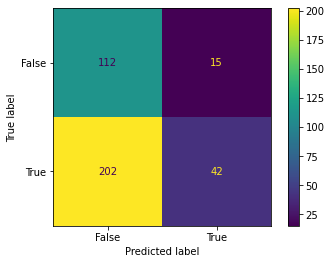

In [12]:
print(confusion_matrix(y_test,y_pred_rf))
print(classification_report(y_test,y_pred_rf))

plot_confusion_matrix(rf,x_test,y_test)

In [14]:
print (accuracy_score(y_test,y_pred_rf)*100)

41.509433962264154
